In [1]:
# Import Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [17]:
BATCH_SIZE=32
IMG_SIZE=48
EPOCHS=100
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "data",
        seed =42,
        shuffle=True,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
)

Found 31944 files belonging to 8 classes.


In [4]:
classes=dataset.class_names
classes
n_classes=len(classes)
n_classes

8

In [5]:
#Displaying Shape of one batch
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 48, 48, 3)
[6 6 6 4 5 0 4 0 5 5 5 5 5 5 5 5 0 5 5 5 4 4 4 4 5 5 4 2 5 5 5 6]


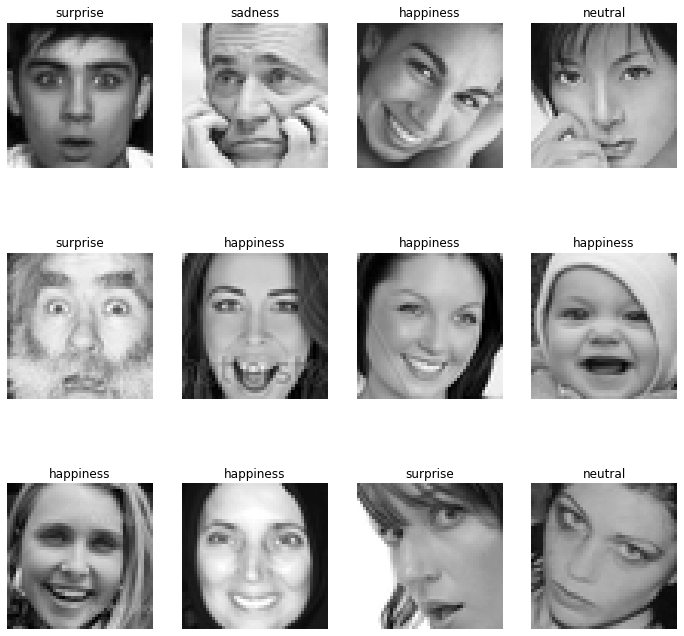

In [6]:
plt.figure(figsize=(12,12))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.title(classes[label_batch[i].numpy()])
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.axis('off')

In [7]:
def train_test_split(dataset, train_per=0.8, test_per=0.1, val_per=0.1, shuffle=True, shuffle_size=10000):
    assert (train_per+test_per+val_per)==1
    
    if shuffle:
        dataset=dataset.shuffle(shuffle_size, seed=42)
    
    train_size= int(train_per* len(dataset))

    train_ds=dataset.take(train_size)
    test=dataset.skip(train_size)
    
    test_size=int(test_per*len(dataset))
    val_size=int(val_per*len(dataset))

#     print(test_size, val_size)
    val_ds=test.take(val_size)
    test_ds=test.skip(test_size)
    
    return train_ds, val_ds, test_ds
        

In [8]:
train_ds, val_ds, test_ds = train_test_split(dataset)
len(train_ds), len(test_ds), len(val_ds)

(799, 101, 99)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Resizing and Rescaling
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),    
])

In [11]:
data_augment=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [12]:
train_ds=train_ds.map(lambda x,y: (data_augment(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape=(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes = len(classes)

model= models.Sequential([
    resize_rescale,
    layers.Conv2D(64,kernel_size=(5,5), activation='elu',input_shape=input_shape, padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(momentum=0.8),
    layers.Conv2D(64,kernel_size=(5,5), activation='elu', padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    layers.Conv2D(128,kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(128,kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    layers.Conv2D(256,kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Conv2D(256,kernel_size=(3,3), activation='elu', padding='same',kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='elu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 48, 48, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 48, 48, 64)          4864      
                                                                 
 batch_normalization (BatchN  (32, 48, 48, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (32, 48, 48, 64)          102464    
                                                                 
 batch_normalization_1 (Batc  (32, 48, 48, 64)         256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (32, 24, 24, 64)        

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
799/799 [==============================] - 17s 22ms/step - loss: 0.7260 - accuracy: 0.7451 - val_loss: 0.6020 - val_accuracy: 0.7812
Epoch 2/100
799/799 [==============================] - 17s 21ms/step - loss: 0.7288 - accuracy: 0.7450 - val_loss: 0.5722 - val_accuracy: 0.7939
Epoch 3/100
799/799 [==============================] - 17s 21ms/step - loss: 0.7278 - accuracy: 0.7469 - val_loss: 0.6048 - val_accuracy: 0.7768
Epoch 4/100
799/799 [==============================] - 17s 22ms/step - loss: 0.7285 - accuracy: 0.7451 - val_loss: 0.5888 - val_accuracy: 0.7948
Epoch 5/100
799/799 [==============================] - 17s 21ms/step - loss: 0.7151 - accuracy: 0.7454 - val_loss: 0.5852 - val_accuracy: 0.7866
Epoch 6/100
799/799 [==============================] - 17s 21ms/step - loss: 0.7197 - accuracy: 0.7475 - val_loss: 0.5626 - val_accuracy: 0.7989
Epoch 7/100
799/799 [==============================] - 17s 21ms/step - loss: 0.7163 - accuracy: 0.7489 - val_loss: 0.5680 - val_ac

In [19]:
scores=model.evaluate(test_ds)

101/101 [==============================] - 2s 8ms/step - loss: 0.4929 - accuracy: 0.8171


In [20]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 799}

In [21]:
history.history['loss'][:5]

[0.7259779572486877,
 0.7288116216659546,
 0.7278001308441162,
 0.7284694910049438,
 0.7151129841804504]

In [22]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

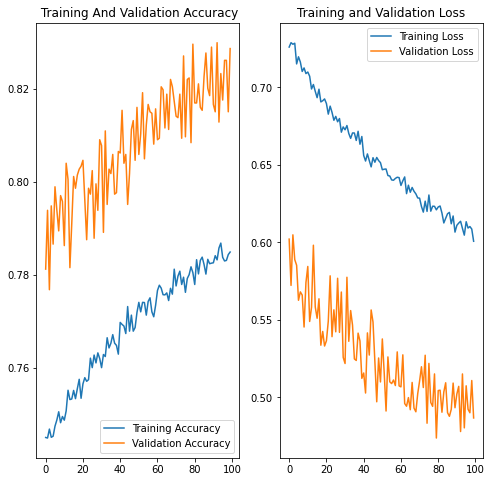

In [23]:
epochs=EPOCHS
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc , label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(" Training And Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show

Predict first test image
actual label neutral
predicted label neutral


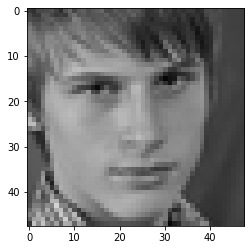

In [59]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print('Predict first test image')
    plt.imshow(first_image)
    print('actual label', classes[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("predicted label", classes[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

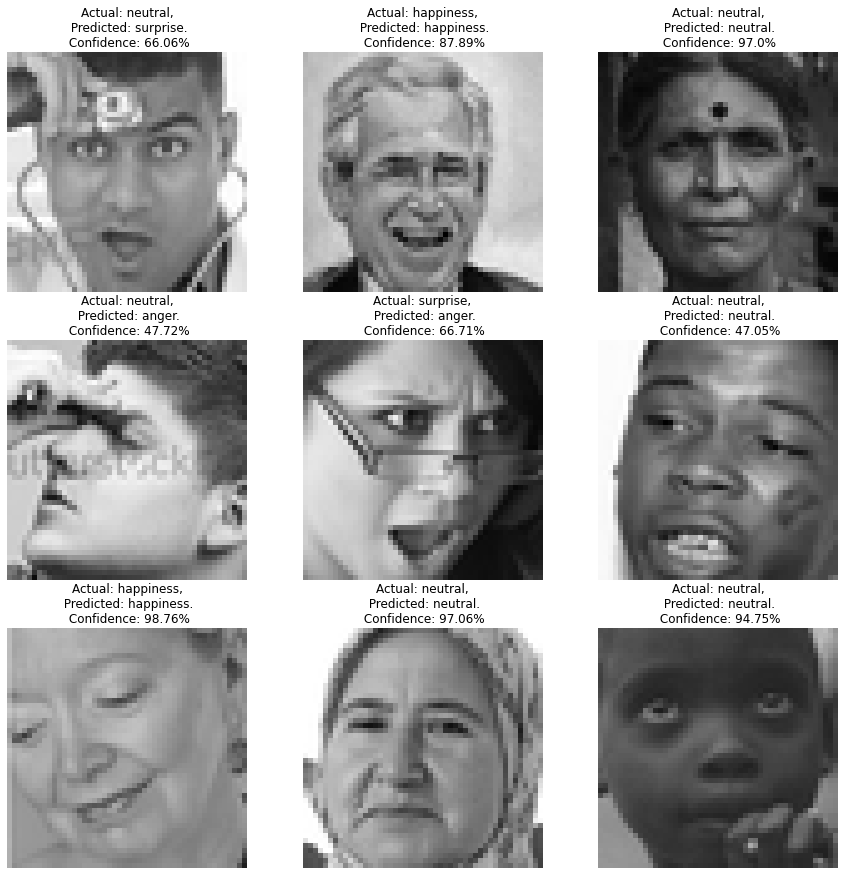

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [65]:
import os
model_version=max([int(i) for i in os.listdir("saved_model") + [0]])+1
model.save(f"saved_model/{model_version}")

INFO:tensorflow:Assets written to: saved_model/1/assets
